# Tutoriel et explication sur le projet Titanic de Kaggle

## But du projet

En s'entrainant sur un jeux de données, le modèle doit prédire si la personne va survivre ou non en fonction de ses différents caractéristiques. 

Deux possibilités de prédiction :

    0 = meurt
    1 = survit
    
Ce notebook aura pour but d'expliquer une démarche afin d'aborder un premier projet Kaggle. Il n'est en aucun cas parfait.

### Import des libraries principales Python afin de faire de la Data Science

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
sns.set(style='white', context='notebook', palette='deep')

import sys
import pandas as pd # Librairie pour stocker des données sous forme de tableau/matrice
import numpy as np #Librairie pour calcule et opération matricielle
import sklearn as sk #Librairie d'outils et de modèle de machine learning
import matplotlib.pyplot as plt # Librairie de Data Visualisation
print('Version de Python : '+sys.version)

Version de Python : 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


### Import des données d'entrainement

La première étape est de récupérer le fichier d'entrainement et de le stocker dans une variable grâce à pandas

In [13]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
IDtest = test["PassengerId"]
train.head(5) # Affichage des 5 premières lignes

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

## Drop les outliers ##

In [17]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [20]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

print(len(dataset))
print(len(test))
print(len(train))

1299
418
881


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [22]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [23]:
train.info()
train.isnull().sum()
## 170 Age null dans notre train et 680

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

#  Analyse des features

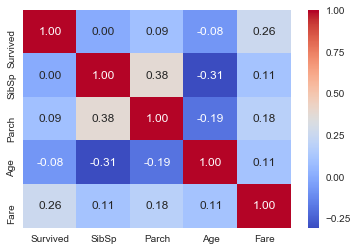

In [24]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Grosse corrélation avec Fare : on peut l'utiliser tel qu'elle, pour les autres: il faut explorer

###  SibSP

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


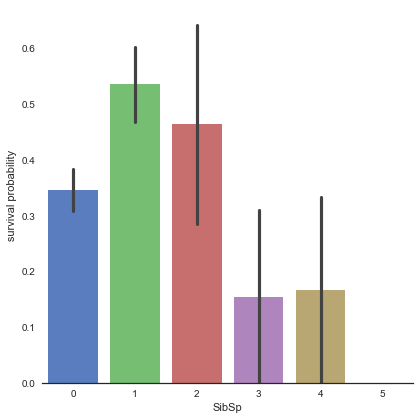

In [25]:
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

On remarque plus on a de famille, plus on a de chance de mourir.

##  Parch

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


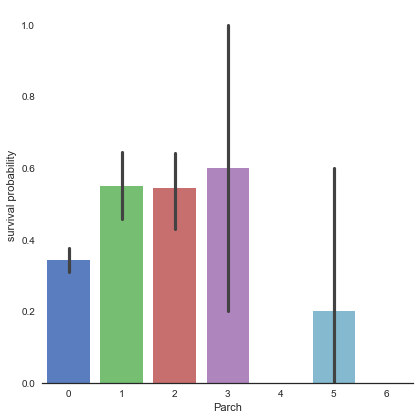

In [26]:
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Attention à la variance. On remarque que les chances pour les célibataire et les grandes familles (3,4,5,6) sont moindre par rapport à une famille petite (1 à 2)

## Age

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


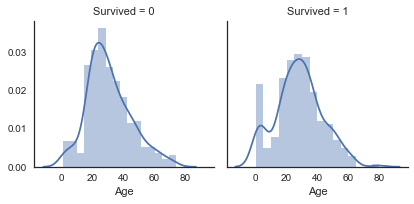

In [27]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

On remarque que les très jeunes ont survécu (petite bosse entre le 0 et 10)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


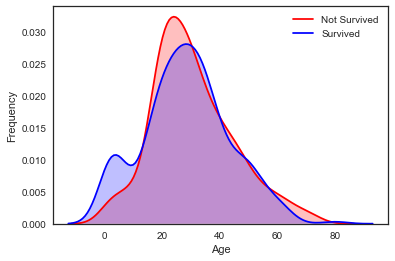

In [28]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

En superposant on le voit très bien

## Fare

Attention il existe une valeur nulle 

In [31]:
dataset["Fare"].isnull().sum()

0

Sachant qu'elle est la seul, on peut la remplacer par la valeur médiane : cela n'a pas un effet important sur la prédiction

In [30]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

On explore la distribution de Fare: 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


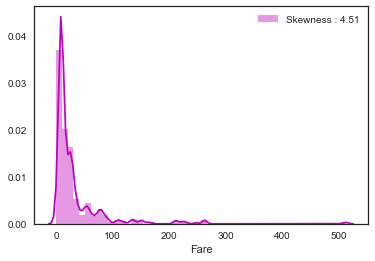

In [32]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

On est donc face à un problème ici. On a des valeurs allant de 0 à 500 : on a donc une grande intervalle. 
Les grandes intervalles sont très mal gérer dans les modèles. On applique donc une fonction log afin de réduire l'étendu de nos variables.

In [35]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


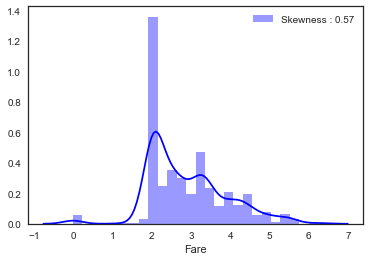

In [36]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# Variable catégorielle : Sex, PClass, Embarked

## Sex

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


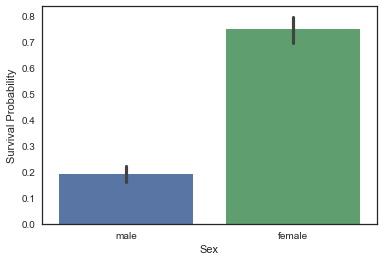

In [37]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

On remarque très clairement que les femmes ont plus de chances de survivre

## Pclass

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


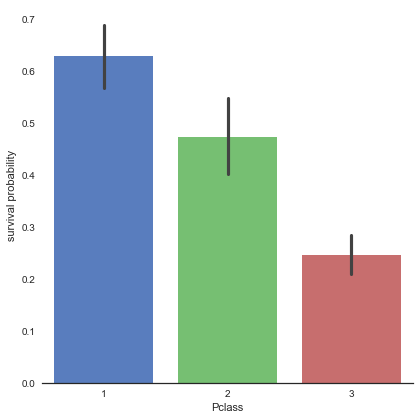

In [38]:
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Pour le coup on remarque que les premières classe ont plus de chance de survivre que les 2nd et 3eme classe

##  Embarked

In [39]:
dataset["Embarked"].isnull().sum()

2

Il existe 2 valeurs nulles à traiter

In [40]:
dataset["Embarked"].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

On peut par exemple la remplacer par la valeur la plus fréquente, soit la porte "S".

In [41]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

##  Occupons nous désormais des valeurs manquantes : (Age = 256)

Une des solutions aurait pu être d'entrainer un modèle pour tenter de prédire ces valeurs manquantes : ça va arriver..

Pour l'instant on va faire plus simple. 
On va récuperer nos index où l'age est null. 
On va tenter de trouver toutes les personne similaire à lui : Même nombre d'enfants, Même nombre de membre dans la famille, Même classe de billet. Nous prennons ensuite l'age médian dans cette population.
Si personne ne lui ressemble, alors on lui met simplement la médiane.

In [45]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

In [46]:
for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

## La création de variables supplémentaires !

La colonne Name nous semble peu informative.. car elle est unique pour chaque passager. Cependant, on peut récuperer quelque chose d'intéressant. Le "titre" , monsieur, madame, maitre, etc.. Cela nous apporte donc une information supplémentaire.

In [48]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Dona              1
Mme               1
Don               1
Lady              1
the Countess      1
Sir               1
Capt              1
Jonkheer          1
Name: Title, dtype: int64

Malheuresement il existe des titre qui sont uniques (Jonkheer, Sir, etc). Nous allons donc les regrouper dans une seule catégorie afin d'avoir plus de volumes et en indiquant que ces titre sont rares.

In [49]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

Désormais on transforme nos données textuelles en chiffres : 

In [50]:
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [51]:
dataset.Title.head()

0    2
1    1
2    1
3    1
4    2
Name: Title, dtype: int64

Puis on supprime la colonne nom..

In [53]:
dataset.drop(labels= ['Name'], axis=1, inplace = True)

## On peut imaginer de créer une nouvelle variable : la taille de la famille

Deux variables nous donnent des informations sur la famille à bord. Parch (enfants) et SibSp(épouses et famille).
On peut les additioner pour obtenir la taille de sa famille totale.

In [55]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


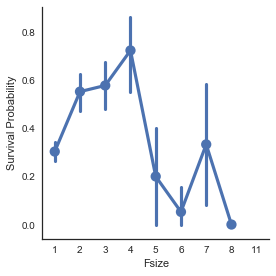

In [56]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

On se retrouve donc avec des tailles de familles différentes. 
On peut donc les regrouper pour obtenir des groupes plus significatifs.

In [57]:
dataset['Seul'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['PetiteF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['NormalF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['GrandeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

On vectorize ensuite nos variables catégorielles : Titre et Porte d'embarquement pour obtenir notre matrice

In [59]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Porte")

In [60]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,PetiteF,NormalF,GrandeF,Title_0,Title_1,Title_2,Title_3,Porte_C,Porte_Q,Porte_S
0,22.0,NaN,1.981001,0,1,3,male,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,female,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,female,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,male,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


## La variable Cabin (1007 valeurs manquantes)

In [61]:
dataset.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

On remarque qu'il y a une lettre devant qu'on pourrait exploiter. Peut être la section où se trouve la cabine.
Cependant, il nous manque un grand nombre de cabine. Pour ceux là, on va indiquer "?".

In [62]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else '?' for i in dataset['Cabin'] ])

In [63]:
dataset.Cabin.head()

0    ?
1    C
2    ?
3    C
4    ?
Name: Cabin, dtype: object

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


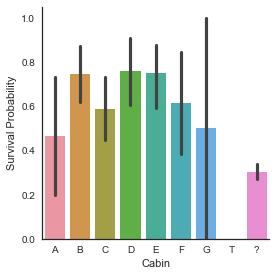

In [65]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','?'])
g = g.set_ylabels("Survival Probability")

In [66]:
dataset["Cabin"].isnull().sum()

0

On a reglé le problème des valeurs nulls pour Cabin !

Comme c'est une variable catégorielle : on vectorize !

In [67]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [70]:
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,...,Porte_S,Cabin_?,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,22.0,1.981001,0,1,3,male,1,0.0,A/5 21171,2,...,1,1,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,female,1,1.0,PC 17599,2,...,0,0,0,0,1,0,0,0,0,0
2,26.0,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,1,...,1,1,0,0,0,0,0,0,0,0
3,35.0,3.972177,0,4,1,female,1,1.0,113803,2,...,1,0,0,0,1,0,0,0,0,0
4,35.0,2.085672,0,5,3,male,0,0.0,373450,1,...,1,1,0,0,0,0,0,0,0,0


## La variable Ticket 

In [72]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

On remarque que là aussi on peut obtenir des infos en utilisant le préfix du ticket. (A/5, PC, STON)

In [74]:
dataset["Ticket"].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '330959', '349216', 'PC 17601', 'PC 17569',
       '335677', 'C.A. 24579', 'PC 17604', '113789', '2677', 'A./5. 2152',
       '345764', '2651', '7546', '11668', '349253', 'SC/Paris 2123',
       '330958', 'S.C./A.4. 23567', '370371', '14311', '2662', '349237',
       '3101295', 'A/4. 39886', 'PC 17572', '2926', '113509', '19947',
       'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144', '2669', '113572',
       '36973', '347088', 'PC 17605', '2661', 'C.A. 29395', 'S.P. 3464',
       '3101281', '315151', 'C.A. 33111', 'S.O.C. 14879', '2680', '1601',
       '348123', '349208', '374746', '248738', '364516', '345767',
       '345779', '330932', '113059', 'SO/C 14885', '3101278',
       'W./

In [75]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

Une nouvelle fois on vectorize notre variable catégorielle 

In [80]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

On fini par vectorizer la PClass aussi !

In [81]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [82]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [83]:
dataset.head()


,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Seul,PetiteF,NormalF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,male,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,female,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,female,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,female,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,male,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Il reste le Sex à transformer en données numérique. Bon c'est binaire donc 0/1

In [99]:
dataset.Sex = dataset['Sex'].map({"male": 0, "female":1})

In [100]:
dataset.head()


,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Seul,PetiteF,NormalF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# Modelisation ! 

In [101]:
train_len = len(train)
train = dataset[:train_len]
test = dataset[train_len:]
# On recupere les données d'entrainement
test.drop(labels=["Survived"],axis = 1,inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
X_train[:5]

,Age,Fare,Parch,Sex,SibSp,Fsize,Seul,PetiteF,NormalF,GrandeF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,2,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,2,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [106]:
Y_train[:5]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Lancement benchmark des modèles :

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

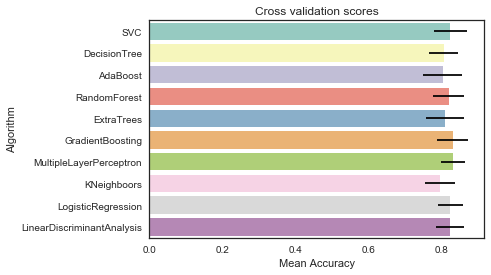

In [112]:
kfold = StratifiedKFold(n_splits=10)
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## On pourrait choisir d'utiliser un modèle unique pour effectuer nos prédictions, mais il y a plus efficace : la combinaison de modèle.

Grâce à un système de vote (soft/hard), on peut assembler des modèles afin d'améliorer nos prédictions. 

Pourquoi fait-on ça?

Les modèles n'utilisent pas le même algorithme et donc le poids et l'importance des variables est différente selon les algos.

Prenons par exemple 
- AdaBoost
- RandomForest
- ExtraTrees
- GradientBoosting
- SVC


## On commence par faire une GridSearch pour AdaBoost afin de l'entrainer

In [114]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_score_)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
0.8251986379114642


[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    2.3s finished


## La même chose pour ExtraTrees

In [115]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
print(gsExtC.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   35.7s finished


0.8286038592508513


## La même chose pour RandomForest !

In [116]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   39.3s finished


0.8354143019296254

## Pareil pour GradientBoosting :-)

In [117]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   19.9s finished


0.8331441543700341

## Et enfin pour SVC !

In [118]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   22.9s finished


0.8331441543700341

## Nos modèles sont entrainés, on va maintenant afficher nos courbes d'apprentissage.

Il est important d'éviter l'overfitting (faire ses propres recherches) et de trouver le bon compromis.

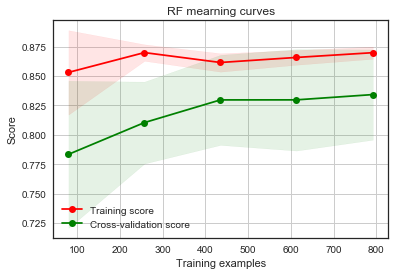

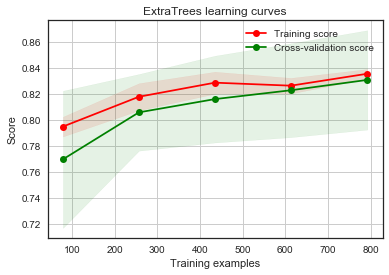

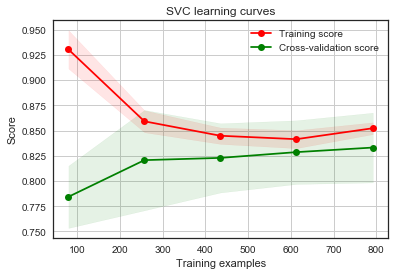

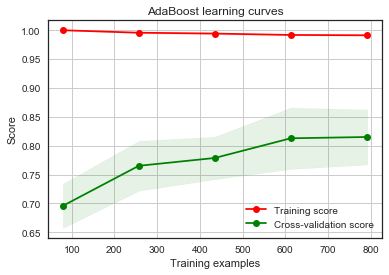

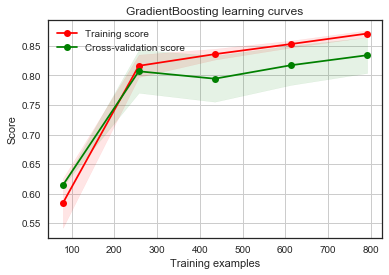

In [120]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

##  On peut ensuite afficher l'importance des variables pour chaque classifieur :

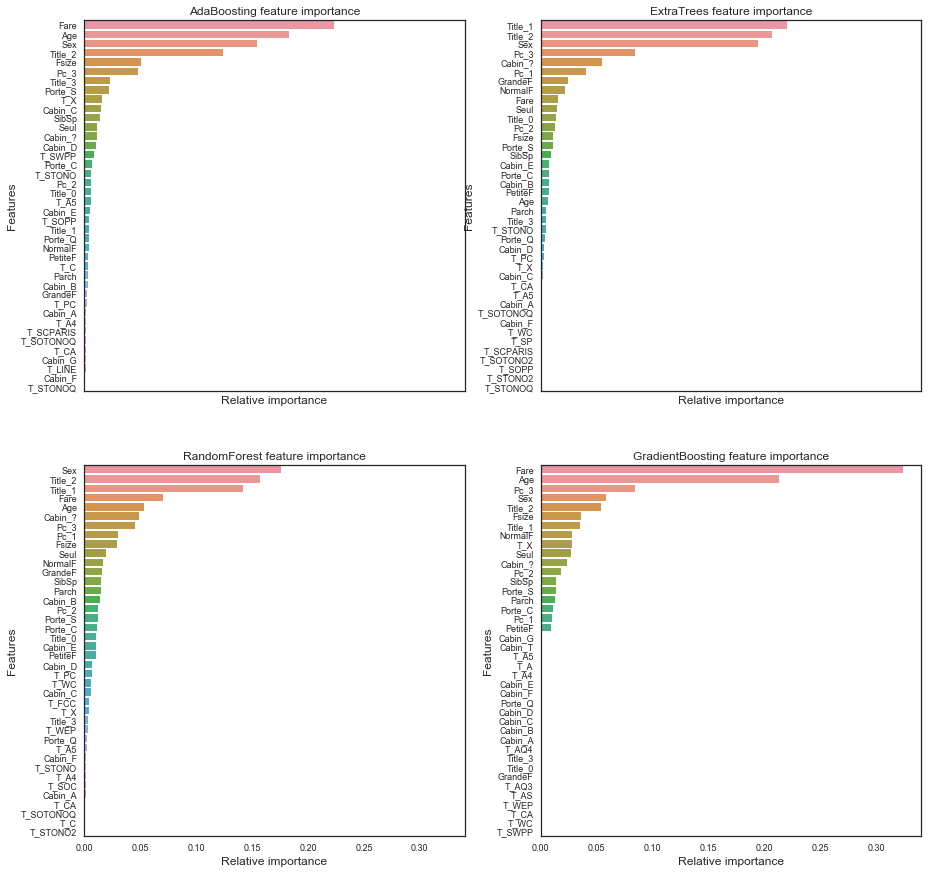

In [121]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

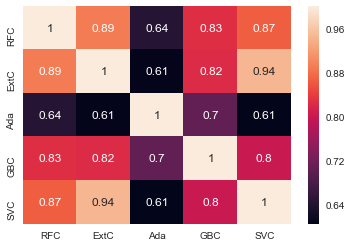

In [122]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [125]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='hard', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [126]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
